In [ ]:
!pip install gtts

In [ ]:
!pip install pretrainedmodels

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import math 
from PIL import Image as im
from gtts import gTTS
from IPython.display import Audio
from scipy.ndimage import interpolation as inter
import sys

In [ ]:
import joblib
import glob
from tqdm import tqdm
import albumentations
import torch
import pretrainedmodels
import torch.nn as nn
from torch.nn import functional as F
import os
import ast
import sklearn.metrics


**Import Pretrained Model**

In [ ]:
!unzip /content/drive/MyDrive/pretrained_model/resnet34_fold0.pth.zip
!unzip /content/drive/MyDrive/pretrained_model/resnet34_fold1.pth.zip
!unzip /content/drive/MyDrive/pretrained_model/resnet34_fold2.pth.zip
!unzip /content/drive/MyDrive/pretrained_model/resnet34_fold3.pth.zip
!unzip /content/drive/MyDrive/pretrained_model/resnet34_fold4.pth.zip

Archive:  /content/drive/MyDrive/pretrained_model/resnet34_fold0.pth.zip
replace resnet34_fold0.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: resnet34_fold0.pth      
Archive:  /content/drive/MyDrive/pretrained_model/resnet34_fold1.pth.zip
replace resnet34_fold1.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: resnet34_fold1.pth      
Archive:  /content/drive/MyDrive/pretrained_model/resnet34_fold2.pth.zip
replace resnet34_fold2.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: resnet34_fold2.pth      
Archive:  /content/drive/MyDrive/pretrained_model/resnet34_fold3.pth.zip
replace resnet34_fold3.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: resnet34_fold3.pth      
Archive:  /content/drive/MyDrive/pretrained_model/resnet34_fold4.pth.zip
replace resnet34_fold4.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: resnet34_fold4.pth      


In [ ]:
map_df = pd.read_csv('/content/drive/MyDrive/pretrained_model/class_map_corrected.csv')

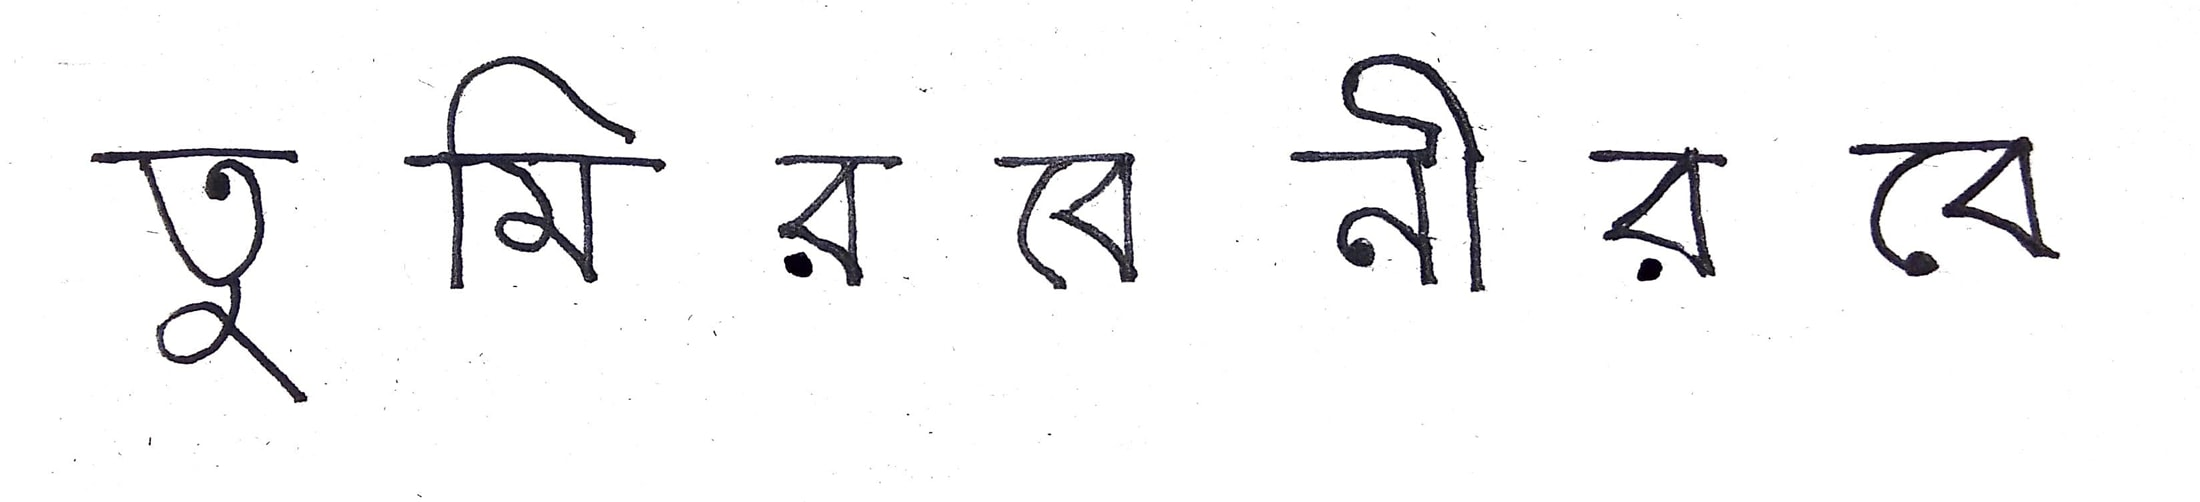

In [ ]:
img = cv2.imread('/content/drive/MyDrive/pretrained_model/TumiRobe_11.jpg')
cv2_imshow(img)

# **Image Segementation**




**Helper Class for Working with the Contours**

In [ ]:
class Rect:
    def __init__(self, x, y, w, h):
        self.x = x
        self.y = y
        self.w = w
        self.h = h

    def getData(self):
        print("Parameters: ", self.x, self.y, self.w, self.h )
    def getCenter(self):
        return int((self.x+self.w)/2), int((self.y+self.h)/2)
    def getRect(self):
        return (self.x,self.y), (self.x+self.w, self.y+self.h)
    def getArea(self):
        return self.w*self.h
    def getDist2(self, R):
        x1, y1 = self.getCenter()
        x2, y2 = R.getCenter()
        return (x1-x2)**2 + (y1-y2)**2
    def mergeRect(self, R):
        self.x = min(self.x, R.x)
        self.y = min(self.y, R.y)
        xmax = max(self.x + self.w, R.x + R.w)
        ymax = max(self.y + self.h, R.y + R.h)
        self.w = xmax - self.x
        self.h = ymax - self.y
        

In [ ]:
def image_segmentation(image):
  box = []
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  ret,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)
  ctrs, heir = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

  th = 5000
  rects = []
  small = []
  for cnt in sorted_ctrs:
      x, y, w, h = cv2.boundingRect(cnt)
      R = Rect(x, y, w, h)
      #R.getData()
      if(R.getArea()>th): 
          rects.append(R)
      else:
          if(R.getArea()>200):
              small.append(R)

  for S in small:
      ds = [S.getDist2(R) for R in rects]
      R = rects[np.argmin(ds)]
      R.mergeRect(S)

  for R in rects:
    x, y, w, h = R.x, R.y, R.w, R.h
    seg = cv2.rectangle(img,(x,y),( x + w, y + h ),(90,0,255),2)
    box.append([x,y,x+w,y+h])

  return box,seg


In [ ]:
boxes, seg = image_segmentation(img)

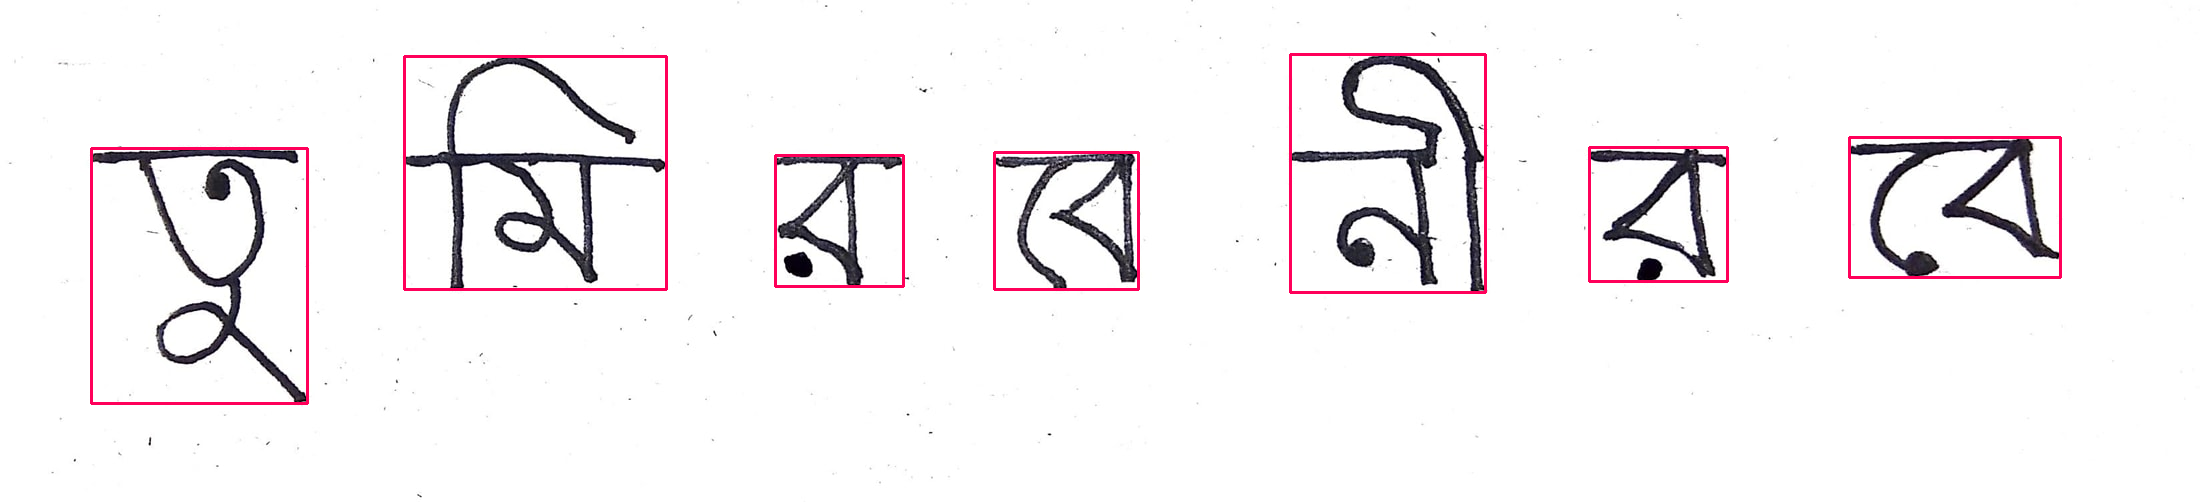

In [ ]:
cv2_imshow(seg)

In [ ]:
boxes

[[91, 148, 307, 403],
 [404, 56, 666, 289],
 [775, 155, 903, 286],
 [994, 152, 1138, 289],
 [1290, 54, 1485, 292],
 [1589, 147, 1727, 281],
 [1849, 137, 2060, 277]]

In [ ]:
final_img = cv2.imread("/content/drive/MyDrive/pretrained_model/TumiRobe_11.jpg")

# **Cropped Image**

In [ ]:
def crop_imgs(img, boxes):
    cropped = []
    for i, box in enumerate(boxes):
        x,y,a,b = box
        if y < 30:
            x,y,a,b = x,y,a,b
        else:
            x,y,a,b = x-15,y-20,a+20,b+25
        crop_img = img[y:b, x:a]
        cropped.append(crop_img)
    return cropped

In [ ]:
cropped = crop_imgs(final_img, boxes)


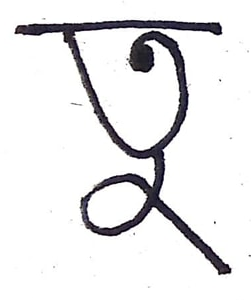

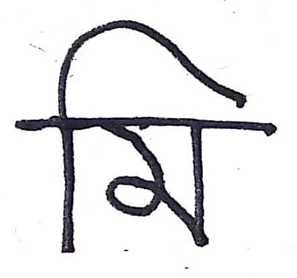

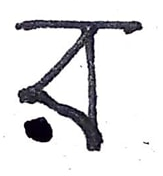

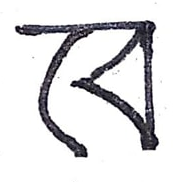

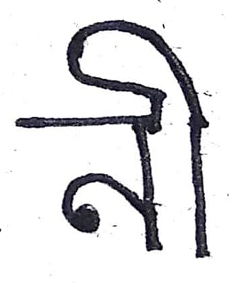

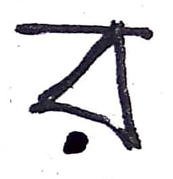

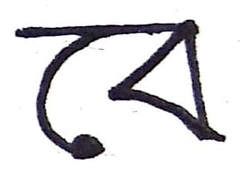

In [ ]:
for img in cropped:
  cv2_imshow(img)
  

# Classify and Combine Grapheme

In [ ]:
MODEL_MEAN = (0.485, 0.456, 0.406)
MODEL_STD = (0.229, 0.224, 0.225)
IMG_HEIGHT = 137
IMG_WIDTH = 236
DEVICE="cuda"

ResNet34 model define

In [ ]:
class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)
        
        self.l0 = nn.Linear(512, 168)
        self.l1 = nn.Linear(512, 11)
        self.l2 = nn.Linear(512, 7)

    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        l0 = self.l0(x)
        l1 = self.l1(x)
        l2 = self.l2(x)
        return l0, l1, l2

In [ ]:
model = ResNet34(pretrained=False)
TEST_BATCH_SIZE = 32

for i in range(5):
    model.load_state_dict(torch.load(f"/content/resnet34_fold{i}.pth"))
    model.to(DEVICE)
    model.eval()


if torch.cuda.is_available(): 
    model.cuda()

**Get Graphemes from map**

In [ ]:
def to_grapheme(map_df, g, v, c):
    grapheme_index = np.argmax(g.cpu().detach().numpy(), axis=1)[0]
    vowel_index = np.argmax(v.cpu().detach().numpy(), axis=1)[0]
    consonant_index = np.argmax(c.cpu().detach().numpy(), axis=1)[0]

    grapheme_df = map_df[map_df['component_type'] == 'grapheme_root']
    vowel_df = map_df[map_df['component_type'] == 'vowel_diacritic']
    consonant_df = map_df[map_df['component_type'] == 'consonant_diacritic']

    grapheme = grapheme_df.loc[grapheme_df['label'] == grapheme_index]['component']
    vowel = vowel_df.loc[vowel_df['label'] == vowel_index]['component']
    consonant = consonant_df.loc[consonant_df['label'] == consonant_index]['component']

    return grapheme.values[0], vowel.values[0], consonant.values[0]

In [ ]:
def combine_graphemes(g,v,c):
    
    
    while (v=='0' and c=='0'):
        return g
    else:
        if ( c == '0'):
            return g+v
        elif ( v == '0'):
            return g+c
        else:
            return g+v+c



def make_sentence(string):
  sentence = " "  
    
  for ele in string:  
      sentence += ele
    
  return sentence

In [ ]:
def classify_grapheme(image):
    img_height = IMG_HEIGHT
    img_width = IMG_WIDTH
    mean = MODEL_MEAN
    std = MODEL_STD

    grapheme_lst = " "

    transform = albumentations.Compose([
            albumentations.Resize(img_height, img_width, always_apply=True),
            albumentations.Normalize(mean, std, always_apply=True)
        ])



    transformed_img = transform(image = img)["image"]
    image = np.moveaxis(transformed_img, -1, 0)
    image = np.expand_dims(image, axis =0)
    image = torch.tensor(image)
    image = image.to(DEVICE, dtype=torch.float)
    g, v, c = model(image)

    gs,vs,cs = to_grapheme(map_df,g,v,c)
    
    print(gs, vs, cs)
   
    grapheme_lst+=(combine_graphemes(gs, vs, cs))


    return grapheme_lst

In [ ]:
word = []
for img in cropped:
  word.append(classify_grapheme(img))



In [ ]:
word

In [ ]:
str1 = " "
for w in word:
    sentence = make_sentence(word)
str1+=sentence




In [ ]:
str1

# **Speech Synthesis**

In [ ]:
def generate_speech(sentence):
    speech = gTTS(sentence, lang='bn')
    return speech

In [ ]:
tts = generate_speech(str1)
tts.save('1.wav')
sound_file = '1.wav'
Audio(sound_file, autoplay=True)
  